If you are running this on Google Colab, you need to uncomment (remove the `#`) and execute the following lines to install the Pyomo package, the solver, and some helper tools. If you are running this on Binder or elsewhere (e.g. your own computer) you can ignore this.

In [1]:
# !pip install pyomo==6.4.1
# !apt install glpk-utils
# !pip install "git+https://github.com/sjpfenninger/sen1511.git#egg=sen1511utils&subdirectory=sen1511utils"

# Getting started

## Python basics

Where to learn the basics of Python?

I recommend spending 2-3 hours going through [QuantEcon: Python Programming for Economics and Finance](https://python-programming.quantecon.org/intro.html). In particular, their chapters "1. About Python" through "6. OOP I: Introduction to Object Oriented Programming" (leaving out chapter 7, which goes into more detail on object-oriented programming); then, all chapters from 8 onwards which give an overview of Python's most important scientific packages.

In any case, you do not need to know much about Python to work with this course and most of it should become clear by looking at the examples.

Some points to note:

* We are working in notebooks. The notebook consists of cells. Some cells - like the one you are looking at right now - contain text. Others, further below, contain code. Cells with code can be executed: while your cursor is inside the cell, press `Shift + Return`.
* Assign something to a variable with "=", e.g.: `x = 1`

* Within the notebook environment, just executing a command will show you the results: writing `1 + 1` in a cell and executing that cell will print `2`. Writing `x` in a cell will print `1` (if the variable x was previously assigned as above).

* Careful: whitespace has meaning in Python - it is used to structure the code into separate logical blocks. For example, to delineate what code is inside an if-block (in this example y only becomes 2 if x > 1, whereas z = 3 is outside the if-block and always executed):
```
if x > 1:
    y = 2
z = 3
```
In this course you can get away with using Python in a basic way more like a scientific calculator. However, some minimal use of control statements (especially "for" loops) will make some steps quicker and easier to do – we will try to explain what is happening when making use of such statements.

## Pyomo basics

Pyomo extends Python to provide a mathematical modelling language with which you can formulate optimisation problems. Like Python itself, it is free and open-source.

At any point, you can refer to the official [Pyomo documentation](https://pyomo.readthedocs.io/en/stable/index.html) to learn more about the many advanced features of Pyomo that we do not cover in the course.

Before using Pyomo, it needs to be imported. By saying import `as pyo` we are defining `pyo` as a shorthand under which to access everything that Pyomo provides. This is best practice: it means that everything coming from Python itself or from other packages is cleanly separated from Pyomo - anytime we need Pyomo, we access it through `pyo`, as you'll see below.

In [2]:
import pyomo.environ as pyo

Next, we define a variable to hold the model. By convention, we call this `model`. The model itself is created by calling `ConcreteModel()` (if you know about object-oriented programming - this creates an object which is a member of the ConcreteModel class).

Later on, we will fill this `ConcreteModel` with data such as variables and constraints.

In [3]:
model = pyo.ConcreteModel(name="Economic dispatch")

Giving the model a `name` is optional but leads to nicer output later on.

Remember, an optimisation problem consists of:

1. variables
2. the objective function, and
3. the constraints.

We now set these up in turn, using the economic dispatch example from the first lecture.

### Variables

Variables, are defined with `Var` objects. We "attach" them to the model as follows: `model.variable_name = ...`. Here, `variable_name` is the name of the variable inside the model, and must therefore be unique to the model. For example:

In [4]:
model.coal_power = pyo.Var(within=pyo.NonNegativeReals)
model.gas_power = pyo.Var(within=pyo.NonNegativeReals)

`within=` is optional and specifies the domain within which the variable can vary.

We could also call the variables `p1` and `p2` as in the lecture. By using more expressive names we are making our model easier to understand.

Commonly used domains for `within` include:

* `pyo.NonNegativeReals`: any real number greater than or equal to zero
* `pyo.Reals`: any real number, including negative ones
* `pyo.Binary`: a variable that can be either 0 or 1 (will be discussed next week)
* `pyo.Integer`: a variable that can be any integer number (will be discussed next week)

By using `pyo.NonNegativeReals`, we are making our life a little easier as we do not need to add extra "greater than or equal to zero" constraints on those variables.

<div class="alert alert-block alert-info">

💡 You can define a large number of variables by first defining sets, i.e. dimensions, over which the variables are valid. For example, you might want to have a variable called `hourly_power_generation` and you might want to model power generation over a longer period of time - say a year, which would be 8760 hours. You can first define a set of timesteps as a list, say `[0, 1, ..., 8759]`, and then tell Pyomo that your variable can take on a value for each timestep by defining the variable over the set.

In our example, instead of defining two separate variables for `coal_power` and `gas_power` we could do it as follows:

```python
power_plant_types = ["coal", "gas"]
model.power_generation = pyo.Var(power_plant_types, within=pyo.NonNegativeReals)

```
<br>

We can then access the two "component variables" as `model.power_generation["coal"]` and `model.power_generation["gas"]`.
    
In the future, we could expand the set of `power_plant_types` by simply expanding the list, say, to `["coal", "gas", "wind", "pv", ...]`.

The [Pyomo documentation](https://pyomo.readthedocs.io/en/stable/index.html) provides more detail on this functionality, including the use of `pyo.Set` objects which provide advanced functionality when dealing with sets.
    
</div>

### Objective function

Just like we did for the variables, we create a `pyo.Objective` and attach it to our model. We're calling it `generation_cost` but any name is possible (for example, you might want to always call the objective the same - `obj` or `objective`).

We give the objective two arguments:

* `expr` is the mathematical expression of the objective functiomn
* `sense` is used to specify whether we are looking for a maximum (`pyo.maximize`) or a minimum (`pyo.minimize`) of this function. If `sense` is omitted, minimisation is assumed.

In [5]:
model.generation_cost = pyo.Objective(
    expr = 3 * model.coal_power + 4 * model.gas_power,
    sense = pyo.minimize
)

<div class="alert alert-block alert-info">

💡 An alternative way to formulate the objective if we use sets (see the box above) would look something like this:
    
```python

prices = {"coal": 3, "gas": 4}

model.generation_cost = pyo.Objective(
    expr = sum(prices[i] * model.power_generation[i] for i in power_plant_types),
    sense = pyo.minimize
)
```

It makes use of additional features of Python, like the `sum()` function, and a so-called "comprehension" that iterates over all elements in the set (`for i in power_plant_types`). With this kind of approach, you can easily build a model with thousands of variables, which can easily be dealt with in mostly automated ways, like here summing up in the objective function.
    
</div>

### Constraints

Finally, we add the constraints, again giving each constraint an `expr` which is its mathematical formulation:

In [6]:
model.coal_min = pyo.Constraint(expr=model.coal_power >= 50)
model.coal_max = pyo.Constraint(expr=model.coal_power <= 300)
model.gas_min = pyo.Constraint(expr=model.gas_power >= 100)
model.gas_max = pyo.Constraint(expr=model.gas_power <= 400)
model.demand = pyo.Constraint(expr=model.gas_power + model.coal_power == 500)

### Solving the model

By default, Pyomo captures only a limited amount of information from the solver. Because we later want to look at dual variables, we need to specify this before solving with the following statement (what exactly the `Suffix`, `direction`, etc are, is not relevant here - simply always use this line of code to ensure that you can later access dual variables):

In [7]:
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

Next, in order to solve the model, we first need to let Pyomo make the connection to a solver - a separate program that knows how to solve a specific kind of optimisation problem. In our case, we are solving a linear (LP) problem and GLPK is a free and open-source solver that uses the Simplex algorithm to solve such problems.

In [8]:
solver = pyo.SolverFactory('glpk')

<div class="alert alert-block alert-info">

💡 In this course we will solve linear and nonlinear problems. Many different solvers exist which implement a range of algorithms to solve optimisation problems. The most performant ones are usually commercial software. For our purposes in this course, free and open-source solvers are more than sufficient however. We will use two solvers:
    
* [GLPK](https://www.gnu.org/software/glpk/): for continuous linear and mixed-integer linear problems
* [IPOPT](https://coin-or.github.io/Ipopt/): for nonlinear problems
    
When later on we deal with nonlinear problems, you will use the IPOPT solver like so:
    
```python
solver = pyo.SolverFactory('ipopt')
```

If you try to solve a nonlinear problem with GLPK, you will get an error. You can solve a linear problem with a nonlinear solver like IPOPT, but that is not usually a good idea: the nonlinear solver is not guaranteed to find the global optimum. So remember to pick the right solver for the job!

</div>

Finally, we can pass our model to the solver, which does its thing and then passes back the solution to Pyomo (or tells us if something went wrong and no optimal solution was found):

In [9]:
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 1700.0, 'Upper bound': 1700.0, 'Number of objectives': 1, 'Number of constraints': 6, 'Number of variables': 3, 'Number of nonzeros': 7, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.005591869354248047}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

You can see that `solver.solve(model)` returns some summary information about the model solution. In this case, you can see `'Termination condition': 'optimal'` -- that's good, we found an optimal solution.

If we do not want to display this information but capture it for later use, we could assign it to a variable, i.e.:

```python
result_object = solver.solve(model)
```

If you want to see the output from the solver while it is solving the model, you can set the `tee` argument to `True` - in the above case, you would see the output from GLPK, giving more detail on what it's doing while solving the problem (e.g. what exact algorithm it is using, etc):

```python
solver.solve(model, tee=True)
```

Now that the model is solved, we can display detailed information about it, including the state of the variables, the objective, and the constraints, with `model.display()`:

In [10]:
model.display()

Model Economic dispatch

  Variables:
    coal_power : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 : 300.0 :  None : False : False : NonNegativeReals
    gas_power : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 : 200.0 :  None : False : False : NonNegativeReals

  Objectives:
    generation_cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 1700.0

  Constraints:
    coal_min : Size=1
        Key  : Lower : Body  : Upper
        None :  50.0 : 300.0 :  None
    coal_max : Size=1
        Key  : Lower : Body  : Upper
        None :  None : 300.0 : 300.0
    gas_min : Size=1
        Key  : Lower : Body  : Upper
        None : 100.0 : 200.0 :  None
    gas_max : Size=1
        Key  : Lower : Body  : Upper
        None :  None : 200.0 : 400.0
    demand : Size=1
        Key  : Lower : Body  : Upper
        None : 500.0 : 500.0 : 500.0


We can use the Python `print` function to set up a nicer overview of the results we care about most, for example:

In [11]:
print(f"Generation costs (objective) = {model.generation_cost()} EUR")
print(f"Gas plant generation = {model.gas_power()} MW")
print(f"Coal plant generation = {model.coal_power()} MW")

Generation costs (objective) = 1700.0 EUR
Gas plant generation = 200.0 MW
Coal plant generation = 300.0 MW


### Dual variables

Recall that constraints in the primal problem are associated with variables in the dual problem.

The solver solves the dual problem for us at the same time as solving the primal problem. Because we set up the model to extract this information earlier (`model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)`), we can now get the shadow prices of the primal problem by looking up the optimal values of the variables of the dual problem like so:

```python
model.dual[model.my_constraint_name]
```

Let's print out the shadow price of some of our constraints:

In [12]:
print(f"Shadow price of `demand` = {model.dual[model.demand]}")
print(f"Shadow price of `coal_max` = {model.dual[model.coal_max]}")
print(f"Shadow price of `coal_min` = {model.dual[model.coal_min]}")

Shadow price of `demand` = 4.0
Shadow price of `coal_max` = -1.0
Shadow price of `coal_min` = 0.0


### An easier way to access results

To make things easier in the course, we provide a function for you to display summary information about a solved model. First, we need to import this helper tool:

In [13]:
from sen1511utils import summarise_results

Then, you can run the function `summarise_results`, giving it the name of your model, in this case, simply `model`, to get an overview of the objective function value, the variables and their value in the solution, as well as the constraints, including the shadow price extracted from the solution of the dual problem:

In [14]:
summarise_results(model)

## Advanced topics

<div class="alert alert-block alert-info">

💡 The following uses Python to a larger extent than the basic overview of Pyomo above. If you are comfortable with using some Python, comfortable with basic programming concepts from other programming languages, or willing to experiment a little bit, then you will be able to exploit the full power of automating tasks to generate a larger set of results quickly by following the recipes below.

</div>

### Modifying and re-running a model, then saving results

Let's set up the exact same model again ("overwriting" the old `model` variable with a new version of the model). The one change is that we replace the value `4` for gas cost in the objective function with a new kind of object - a mutable (changeable) parameter represented by `pyo.Param(mutable=True)`. We call this parameters `gas_cost` and attach it to the `model`. The rest of the model setup is exactly as above, but all combined in one notebook cell.

Parameters are fixed while the model is optimised - unlike variables that the solver algorithm can change to find an optimal solution.

However, by creating a mutable parameter we are telling Pyomo that we would like to change this parameter's value in between several optimisation runs.

In [15]:
model = pyo.ConcreteModel(name="Economic dispatch, version 2")

model.gas_cost = pyo.Param(mutable=True)

model.coal_power = pyo.Var(within=pyo.NonNegativeReals)
model.gas_power = pyo.Var(within=pyo.NonNegativeReals)

model.generation_cost = pyo.Objective(
    expr = 3 * model.coal_power + model.gas_cost * model.gas_power,
    sense = pyo.minimize
)

model.coal_min = pyo.Constraint(expr=model.coal_power >= 50)
model.coal_max = pyo.Constraint(expr=model.coal_power <= 300)
model.gas_min = pyo.Constraint(expr=model.gas_power >= 100)
model.gas_max = pyo.Constraint(expr=model.gas_power <= 400)
model.demand = pyo.Constraint(expr=model.gas_power + model.coal_power == 500)

model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

Now that we have a parameter in the model, we can solve the model several times with different values for this parameter. First, we define a list of values we want to explore:

In [16]:
gas_costs = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Next, we are going to iterate over each value in this list, set the `gas_cost` parameter to the current value from the list, solve the model, and store three results we care about - the generation cost (objective function value), gas power and coal power generation, into a list that we call `result_accumulator` - since it accumulates results (this happens with the Python functionality to append a new entry to an existing list: `result_accumulator.append(...)`).

In [17]:
result_accumulator = []

for i in gas_costs:
    model.gas_cost = i
    solver.solve(model)
    result_accumulator.append([model.generation_cost(), model.gas_power(), model.coal_power()])

Finally - we are going to turn the accumulated results into a `DataFrame` - a data structure provided by the `pandas` package which represents a table of data that is easy to further process, analyse, or save to a file. For that, we import the pandas package and make it available as `pd`, then create a DataFrame from the results, giving names for the columns, and specifying that we want the index (first) column to be the `gas_costs` which we iterated over to build these results).

In [18]:
import pandas as pd

results = pd.DataFrame(result_accumulator, columns=["generation cost", "gas power", "coal power"], index=gas_costs)

We can look at this table:

In [19]:
results

,generation cost,gas power,coal power
1.0,700.0,400.0,100.0
1.5,900.0,400.0,100.0
2.0,1100.0,400.0,100.0
2.5,1300.0,400.0,100.0
3.0,1500.0,200.0,300.0
3.5,1600.0,200.0,300.0
4.0,1700.0,200.0,300.0
4.5,1800.0,200.0,300.0
5.0,1900.0,200.0,300.0


And we can save it to a tabular CSV file that can be opened in Excel for further analysis:

In [20]:
results.to_csv("results.csv")

Finally, we can also easily plot these results:

<AxesSubplot:xlabel='gas cost', ylabel='cost (EUR) / power (MW)'>

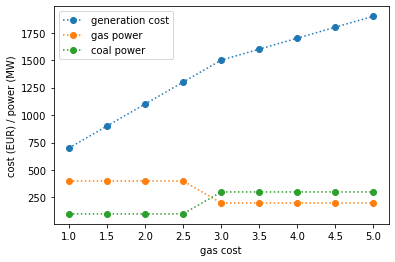

In [21]:
results.plot(xlabel="gas cost", ylabel="cost (EUR) / power (MW)", marker='o', linestyle=':')